In [1]:
# Import Libraries
import os
import gc
import shutil
import cv2
import numpy as np 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
from glob import glob
import xml.etree.ElementTree as xet
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

# GPU
import torch
from numba import cuda

In [2]:
path = glob('/kaggle/input/indian-vehicle-dataset/google_images/*.xml')
print(len(path))


labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['plate_number'].append(plate_number)

440


In [3]:
new_paths = glob('/kaggle/input/indian-vehicle-dataset/State-wise_OLX/*/*.xml')
print(len(new_paths))


new_labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in new_paths:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    new_labels_dict['filepath'].append(filename)
    new_labels_dict['xmin'].append(xmin)
    new_labels_dict['xmax'].append(xmax)
    new_labels_dict['ymin'].append(ymin)
    new_labels_dict['ymax'].append(ymax)
    new_labels_dict['plate_number'].append(plate_number)

603


In [4]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/kaggle/input/indian-vehicle-dataset/google_im...,29,161,265,325,MH06AW8929
1,/kaggle/input/indian-vehicle-dataset/google_im...,144,369,82,230,DL1N4268
2,/kaggle/input/indian-vehicle-dataset/google_im...,254,472,516,570,MH03BS7778
3,/kaggle/input/indian-vehicle-dataset/google_im...,267,500,511,574,TN19TC91
4,/kaggle/input/indian-vehicle-dataset/google_im...,231,434,82,156,KL01CC50


In [5]:
new_df = pd.DataFrame(new_labels_dict)
new_df.to_csv('new_labels.csv',index=False)
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/kaggle/input/indian-vehicle-dataset/State-wis...,105,167,183,197,HP54C6564
1,/kaggle/input/indian-vehicle-dataset/State-wis...,81,131,124,137,HP302165
2,/kaggle/input/indian-vehicle-dataset/State-wis...,30,74,97,111,HP01A7630
3,/kaggle/input/indian-vehicle-dataset/State-wis...,102,165,352,368,HP52B5958
4,/kaggle/input/indian-vehicle-dataset/State-wis...,86,160,194,218,HP23A6365


In [6]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/kaggle/input/indian-vehicle-dataset/google_images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height

df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/kaggle/input/indian-vehicle-dataset/google_im...,29,161,265,325,MH06AW8929,/kaggle/input/indian-vehicle-dataset/google_im...,500,409
1,/kaggle/input/indian-vehicle-dataset/google_im...,144,369,82,230,DL1N4268,/kaggle/input/indian-vehicle-dataset/google_im...,509,290
2,/kaggle/input/indian-vehicle-dataset/google_im...,254,472,516,570,MH03BS7778,/kaggle/input/indian-vehicle-dataset/google_im...,768,1024
3,/kaggle/input/indian-vehicle-dataset/google_im...,267,500,511,574,TN19TC91,/kaggle/input/indian-vehicle-dataset/google_im...,1024,706
4,/kaggle/input/indian-vehicle-dataset/google_im...,231,434,82,156,KL01CC50,/kaggle/input/indian-vehicle-dataset/google_im...,500,234


In [7]:
# parsing
def newparsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/kaggle/input/indian-vehicle-dataset/State-wise_OLX/{name[:2]}/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height

new_df[['filename','width','height']] = new_df['filepath'].apply(newparsing).apply(pd.Series)
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/kaggle/input/indian-vehicle-dataset/State-wis...,105,167,183,197,HP54C6564,/kaggle/input/indian-vehicle-dataset/State-wis...,272,306
1,/kaggle/input/indian-vehicle-dataset/State-wis...,81,131,124,137,HP302165,/kaggle/input/indian-vehicle-dataset/State-wis...,272,204
2,/kaggle/input/indian-vehicle-dataset/State-wis...,30,74,97,111,HP01A7630,/kaggle/input/indian-vehicle-dataset/State-wis...,191,139
3,/kaggle/input/indian-vehicle-dataset/State-wis...,102,165,352,368,HP52B5958,/kaggle/input/indian-vehicle-dataset/State-wis...,272,590
4,/kaggle/input/indian-vehicle-dataset/State-wis...,86,160,194,218,HP23A6365,/kaggle/input/indian-vehicle-dataset/State-wis...,272,297


In [8]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/kaggle/input/indian-vehicle-dataset/google_im...,29,161,265,325,MH06AW8929,/kaggle/input/indian-vehicle-dataset/google_im...,500,409,0.190000,0.721271,0.264000,0.146699
1,/kaggle/input/indian-vehicle-dataset/google_im...,144,369,82,230,DL1N4268,/kaggle/input/indian-vehicle-dataset/google_im...,509,290,0.503929,0.537931,0.442043,0.510345
2,/kaggle/input/indian-vehicle-dataset/google_im...,254,472,516,570,MH03BS7778,/kaggle/input/indian-vehicle-dataset/google_im...,768,1024,0.472656,0.530273,0.283854,0.052734
3,/kaggle/input/indian-vehicle-dataset/google_im...,267,500,511,574,TN19TC91,/kaggle/input/indian-vehicle-dataset/google_im...,1024,706,0.374512,0.768414,0.227539,0.089235
4,/kaggle/input/indian-vehicle-dataset/google_im...,231,434,82,156,KL01CC50,/kaggle/input/indian-vehicle-dataset/google_im...,500,234,0.665000,0.508547,0.406000,0.316239


In [9]:
# center_x, center_y, width , height
new_df['center_x'] = (new_df['xmax'] + new_df['xmin'])/(2*new_df['width'])
new_df['center_y'] = (new_df['ymax'] + new_df['ymin'])/(2*new_df['height'])

new_df['bb_width'] = (new_df['xmax'] - new_df['xmin'])/new_df['width']
new_df['bb_height'] = (new_df['ymax'] - new_df['ymin'])/new_df['height']
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/kaggle/input/indian-vehicle-dataset/State-wis...,105,167,183,197,HP54C6564,/kaggle/input/indian-vehicle-dataset/State-wis...,272,306,0.500000,0.620915,0.227941,0.045752
1,/kaggle/input/indian-vehicle-dataset/State-wis...,81,131,124,137,HP302165,/kaggle/input/indian-vehicle-dataset/State-wis...,272,204,0.389706,0.639706,0.183824,0.063725
2,/kaggle/input/indian-vehicle-dataset/State-wis...,30,74,97,111,HP01A7630,/kaggle/input/indian-vehicle-dataset/State-wis...,191,139,0.272251,0.748201,0.230366,0.100719
3,/kaggle/input/indian-vehicle-dataset/State-wis...,102,165,352,368,HP52B5958,/kaggle/input/indian-vehicle-dataset/State-wis...,272,590,0.490809,0.610169,0.231618,0.027119
4,/kaggle/input/indian-vehicle-dataset/State-wis...,86,160,194,218,HP23A6365,/kaggle/input/indian-vehicle-dataset/State-wis...,272,297,0.452206,0.693603,0.272059,0.080808


In [10]:
data = pd.concat([df,new_df]).sample(frac=1).reset_index(drop=True)
data.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/kaggle/input/indian-vehicle-dataset/State-wis...,163,217,153,171,GA07K6090,/kaggle/input/indian-vehicle-dataset/State-wis...,272,242,0.698529,0.669421,0.198529,0.074380
1,/kaggle/input/indian-vehicle-dataset/google_im...,185,324,114,148,MH20BY3665,/kaggle/input/indian-vehicle-dataset/google_im...,500,333,0.509000,0.393393,0.278000,0.102102
2,/kaggle/input/indian-vehicle-dataset/google_im...,115,286,158,249,HP896786,/kaggle/input/indian-vehicle-dataset/google_im...,386,529,0.519430,0.384688,0.443005,0.172023
3,/kaggle/input/indian-vehicle-dataset/State-wis...,97,202,269,298,ML064696,/kaggle/input/indian-vehicle-dataset/State-wis...,272,484,0.549632,0.585744,0.386029,0.059917
4,/kaggle/input/indian-vehicle-dataset/State-wis...,124,200,207,223,KL07BU7707,/kaggle/input/indian-vehicle-dataset/State-wis...,272,363,0.595588,0.592287,0.279412,0.044077


In [11]:
df_metadata = pd.DataFrame()
df_metadata = data.rename(columns={"filename": "image_path"})
df_metadata.head()

# Extract individual bbox coordinates
df_metadata["x1_bbox"] = df_metadata["xmin"] 
df_metadata["y1_bbox"] = df_metadata["ymin"] 
df_metadata["x2_bbox"] = df_metadata["xmax"] 
df_metadata["y2_bbox"] = df_metadata["ymax"]
df_metadata["xmid"] = df_metadata["center_x"]
df_metadata["ymid"] = df_metadata["center_y"]
df_metadata = df_metadata.drop(columns=["filepath", "xmin", "xmax", "ymin", "ymax", "width", "height", "center_x", "center_y"])
df_metadata.head()

,plate_number,image_path,bb_width,bb_height,x1_bbox,y1_bbox,x2_bbox,y2_bbox,xmid,ymid
0,GA07K6090,/kaggle/input/indian-vehicle-dataset/State-wis...,0.198529,0.074380,163,153,217,171,0.698529,0.669421
1,MH20BY3665,/kaggle/input/indian-vehicle-dataset/google_im...,0.278000,0.102102,185,114,324,148,0.509000,0.393393
2,HP896786,/kaggle/input/indian-vehicle-dataset/google_im...,0.443005,0.172023,115,158,286,249,0.519430,0.384688
3,ML064696,/kaggle/input/indian-vehicle-dataset/State-wis...,0.386029,0.059917,97,269,202,298,0.549632,0.585744
4,KL07BU7707,/kaggle/input/indian-vehicle-dataset/State-wis...,0.279412,0.044077,124,207,200,223,0.595588,0.592287


In [12]:
### split the data into train and test
df_train = data.iloc[:800]
df_test = data.iloc[850:]
df_val = data.iloc[800:850]

In [13]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics
!pip install -U ray[tune]

Cloning into 'ultralytics'...
remote: Enumerating objects: 55481, done.
remote: Counting objects: 100% (1009/1009), done.
remote: Compressing objects: 100% (545/545), done.
remote: Total 55481 (delta 774), reused 477 (delta 464), pack-reused 54472 (from 2)
Receiving objects: 100% (55481/55481), 31.42 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (40924/40924), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 16.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 25.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.9.0
    Uninstalling ray-2.9.0:
      Successfully uninstalled ray-2.9.0


In [14]:
!mkdir "/kaggle/working/ultralytics/datasets"
!mkdir "/kaggle/working/ultralytics/datasets/train"
!mkdir "/kaggle/working/ultralytics/datasets/val"
!mkdir "/kaggle/working/ultralytics/datasets/test"

In [15]:
yaml_file_path = '/kaggle/working/ultralytics/ultralytics/cfg/models/v3/yolov3-tiny.yaml'

with open(yaml_file_path, 'w') as file:
    file.write('''
    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15 (P5/32-large)

   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P4
   [-1, 1, Conv, [256, 1, 1]],  # 19 (P4/16-medium)

   [[19, 15], 1, Detect, [nc]],  # Detect(P4, P5)
  ]
  
    ''')


# Verify
with open(yaml_file_path, 'r') as file:
    modified_content = file.read()
    print(modified_content)


    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15

In [16]:
train_folder = '/kaggle/working/ultralytics/datasets/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(train_folder,image_name)
        dst_label_file = os.path.join(train_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

/kaggle/input/indian-vehicle-dataset/State-wise_OLX/NL/NL1.jpg
/kaggle/input/indian-vehicle-dataset/State-wise_OLX/MH/MH5.jpg


In [17]:
test_folder = '/kaggle/working/ultralytics/datasets/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(test_folder,image_name)
        dst_label_file = os.path.join(test_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [18]:
val_folder = '/kaggle/working/ultralytics/datasets/val'

values = df_val[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(val_folder,image_name)
        dst_label_file = os.path.join(val_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [19]:
%%writefile /kaggle/working/ultralytics/custom_dataset.yaml
train: /kaggle/working/ultralytics/datasets/train
val: /kaggle/working/ultralytics/datasets/val
test: /kaggle/working/ultralytics/datasets/test
    
nc: 1
    
names: [
    'license_plate'
]

Writing /kaggle/working/ultralytics/custom_dataset.yaml


In [20]:
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=05659ecbd6a2b49b4f6eb67fb44701a250b110ae0ddaf54305779dc9e166e683
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  8% |  2% |


In [21]:
!wandb disabled
!yolo train model=yolov3-tinyu.pt data="./ultralytics/custom_dataset.yaml" epochs=100 verbose=True batch=32

W&B disabled.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100%|███████████████████████████████████████| 23.3M/23.3M [00:00<00:00, 159MB/s]
Ultralytics 8.3.104 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov3-tinyu.pt, data=./ultralytics/custom_dataset.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=Tru

In [22]:
training_results = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,14.0213,1.60284,4.57271,1.28757,0.91518,0.94000,0.91421,0.62729,1.12312,2.28254,1.07398,0.000480,0.000480,0.000480
1,2,24.2641,1.07375,0.80547,1.01320,0.97777,0.87977,0.93534,0.63224,1.19736,0.94445,1.07428,0.000970,0.000970,0.000970
2,3,34.5292,1.03145,0.70399,1.02034,0.95318,0.92000,0.95763,0.68081,1.14052,0.86521,1.07320,0.001451,0.001451,0.001451
3,4,44.9084,1.04181,0.66850,1.00538,0.88504,0.92000,0.92188,0.58971,1.26591,0.89705,1.10772,0.001921,0.001921,0.001921
4,5,55.0918,0.97801,0.64088,0.99467,0.95589,0.98000,0.96815,0.68776,1.08973,0.69039,1.03696,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,978.6930,0.46904,0.28450,0.84522,0.97999,0.97968,0.97187,0.82240,0.68299,0.38268,0.87864,0.000119,0.000119,0.000119
96,97,988.7300,0.44555,0.27515,0.82356,0.98000,0.97983,0.97305,0.82277,0.69537,0.38040,0.88273,0.000099,0.000099,0.000099
97,98,998.8050,0.43981,0.27132,0.82683,0.97936,0.98000,0.97387,0.82170,0.69481,0.38516,0.88076,0.000079,0.000079,0.000079
98,99,1008.9600,0.43789,0.27050,0.82061,0.97931,0.98000,0.97365,0.82782,0.69593,0.37668,0.88160,0.000060,0.000060,0.000060


In [23]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

fig.show(iframe_connected=True)

In [24]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall"]
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=subplot_titles, 
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )
    
    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=300,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [25]:
!yolo val model="/kaggle/working/runs/detect/train/weights/best.pt" data="./ultralytics/custom_dataset.yaml" split="test"

Ultralytics 8.3.104 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv3-tiny summary (fused): 34 layers, 12,128,178 parameters, 0 gradients, 18.9 GFLOPs
val: Scanning /kaggle/working/ultralytics/datasets/test... 193 images, 0 backgro
val: New cache created: /kaggle/working/ultralytics/datasets/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        193        193      0.984      0.964      0.993      0.831
Speed: 1.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


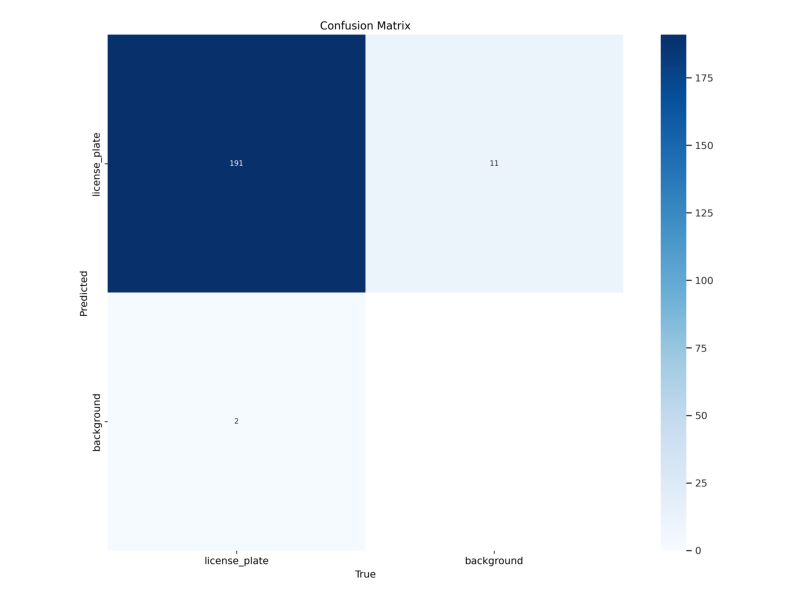

In [26]:
fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("/kaggle/working/runs/detect/val/confusion_matrix.png")
plt.imshow(cm_img)
plt.axis("off")
fig.show()

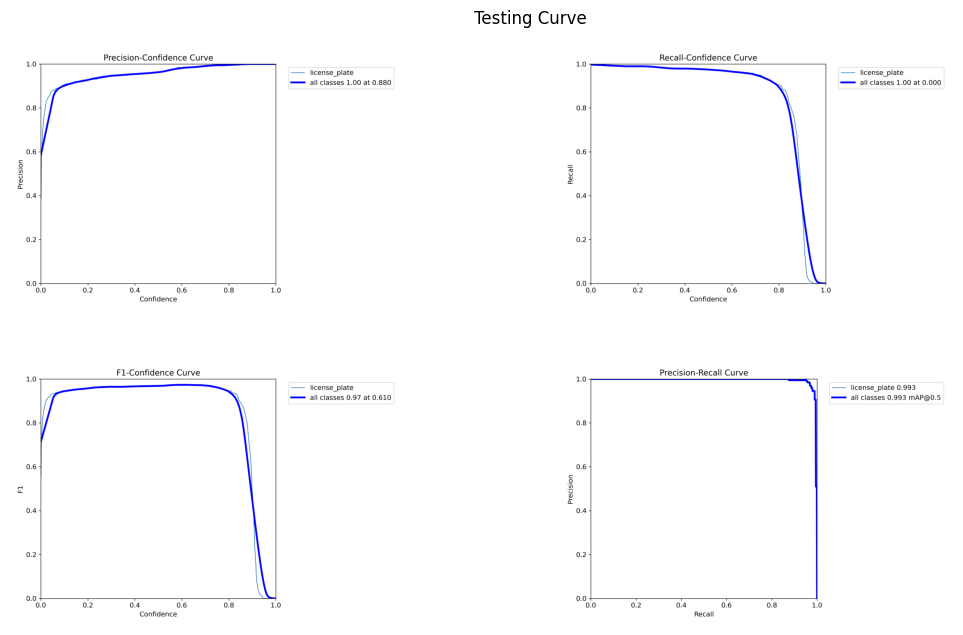

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/kaggle/working/runs/detect/val/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')
    
# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show
plt.show()

In [28]:
df_results = df_test[["filename", "plate_number", "xmin", "ymin", "xmax", "ymax"]]
df_results = df_results.rename(columns={"filename": "image_path", "xmin": "x1_bbox", "ymin": "y1_bbox", "xmax": "x2_bbox", "ymax": "y2_bbox"})
df_results = df_results.reset_index(drop=True)
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,/kaggle/input/indian-vehicle-dataset/State-wis...,AS04X2780,100,135,172,151
1,/kaggle/input/indian-vehicle-dataset/State-wis...,SK01PA7708,104,237,183,256
2,/kaggle/input/indian-vehicle-dataset/State-wis...,AR169723,54,234,97,261
3,/kaggle/input/indian-vehicle-dataset/State-wis...,AP31EF1155,98,197,174,216
4,/kaggle/input/indian-vehicle-dataset/google_im...,MH20BN3525,179,235,352,274
...,...,...,...,...,...,...
188,/kaggle/input/indian-vehicle-dataset/State-wis...,PB10CX0209,111,152,170,165
189,/kaggle/input/indian-vehicle-dataset/State-wis...,OD02AP3010,89,279,184,297
190,/kaggle/input/indian-vehicle-dataset/State-wis...,PY02L4602,96,217,161,234
191,/kaggle/input/indian-vehicle-dataset/google_im...,TN52U1580,138,249,348,301


In [29]:
# Get Bounding Box Predictions
from ultralytics import YOLO

yolo_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []
for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)
    
    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

In [30]:
df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,/kaggle/input/indian-vehicle-dataset/State-wis...,AS04X2780,100,135,172,151,"[[99, 135, 172, 151]]",[0.91]
1,/kaggle/input/indian-vehicle-dataset/State-wis...,SK01PA7708,104,237,183,256,"[[104, 237, 182, 255]]",[0.9]
2,/kaggle/input/indian-vehicle-dataset/State-wis...,AR169723,54,234,97,261,"[[54, 234, 95, 260]]",[0.88]
3,/kaggle/input/indian-vehicle-dataset/State-wis...,AP31EF1155,98,197,174,216,"[[97, 197, 176, 215]]",[0.9]
4,/kaggle/input/indian-vehicle-dataset/google_im...,MH20BN3525,179,235,352,274,"[[179, 232, 352, 273]]",[0.92]
...,...,...,...,...,...,...,...,...
188,/kaggle/input/indian-vehicle-dataset/State-wis...,PB10CX0209,111,152,170,165,"[[111, 152, 170, 164]]",[0.87]
189,/kaggle/input/indian-vehicle-dataset/State-wis...,OD02AP3010,89,279,184,297,"[[95, 279, 183, 297]]",[0.9]
190,/kaggle/input/indian-vehicle-dataset/State-wis...,PY02L4602,96,217,161,234,"[[95, 214, 161, 235]]",[0.9]
191,/kaggle/input/indian-vehicle-dataset/google_im...,TN52U1580,138,249,348,301,"[[134, 247, 348, 300]]",[0.9]


/kaggle/input/indian-vehicle-dataset/State-wise_OLX/SK/SK3.jpg


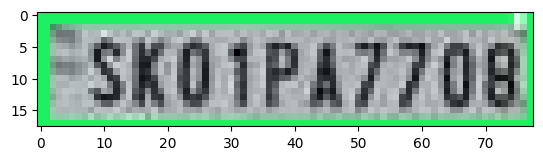

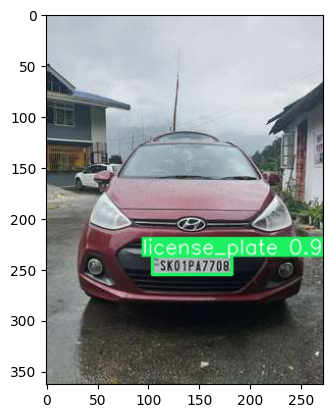

/kaggle/input/indian-vehicle-dataset/State-wise_OLX/AR/AR3.jpg


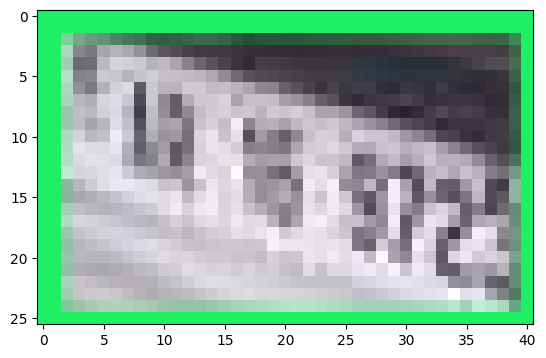

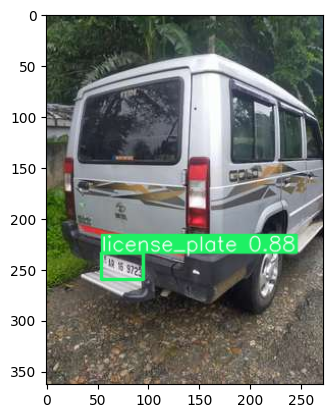

/kaggle/input/indian-vehicle-dataset/State-wise_OLX/AP/AP27.jpg


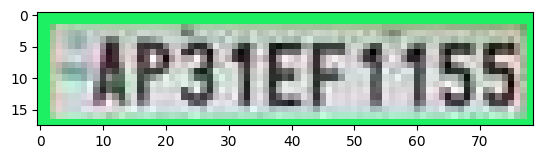

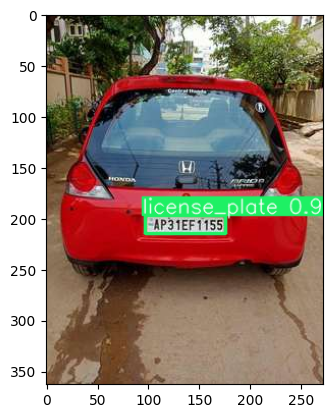

/kaggle/input/indian-vehicle-dataset/google_images/fc1f58f0-2f54-4545-8915-2936d08dcce1___new_Skoda_Laura_DSG_Long_Term_Review-125.jpg.jpeg


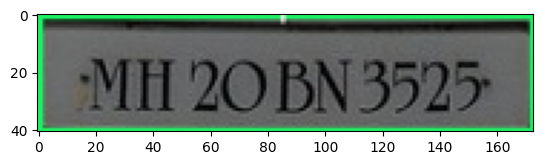

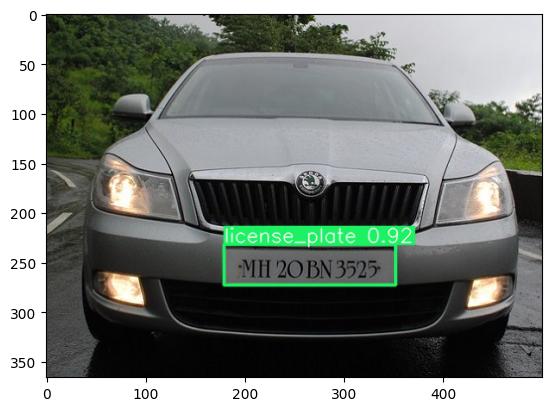

/kaggle/input/indian-vehicle-dataset/google_images/a508ecb5-bfdd-46ba-8640-bb827b7c089c___Volkswagen-Polo.jpg.jpeg


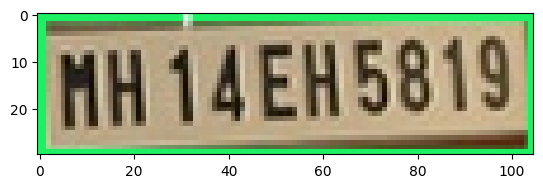

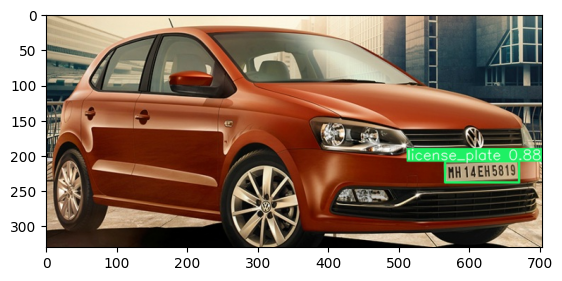

In [31]:
from ultralytics.utils.plotting import Annotator

def show_plate_detection(idx):
    # Original Image
    ori_path = df_results["image_path"][idx]
    print(ori_path)
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    # Annotate Box
    annotator = Annotator(ori_image)
    boxes = df_results["pred_bbox"][idx]
    confs = df_results["confidence"][idx]
    for i, box in enumerate(boxes):
        annotator.box_label(box=box, label="license_plate " + (str(confs[i])), color=(30, 240, 100))

        # Get Plate Object
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = ori_image[y1:y2, x1:x2]
        plt.imshow(roi)
        plt.show()

    # Show Image
    frame = annotator.result()
    plt.imshow(frame)
    plt.show()

idxs = [1, 2, 3, 4, 5]
for idx in idxs:
    show_plate_detection(idx)

In [32]:
!pip install easyocr

In [33]:
import easyocr

# initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

def get_text_easyocr(idx):
    ori_path = df_results["image_path"][idx]
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
    text_list = []
    bboxs = df_results["pred_bbox"][idx]
    for bbox in bboxs:
        # Crop Image with Bounding Box
        crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        
        # Extract Plate Number
        result = reader.readtext(crop_image)
        text_output = ' '.join([res[1] for res in result])
        text_output = text_output.strip()
        if(len(text_output)>0):
            
            # Clean Text
            del_punc_list = [" ", "·", ":", "-", "_"]
            clean_text = re.sub(r"[ ·:-]", "", text_output)
            clean_text = clean_text.replace("O", "0")
            clean_text = clean_text.replace("I", "1")
            clean_text = clean_text.upper()
            text_list.append(clean_text)
            
    return text_list

In [34]:
!pip install onnxruntime
import re
idxs = list(np.arange(0, 193))
text_results = tqdm([get_text_easyocr(idx) for idx in idxs])
text_results = [text[0] if len(text)>0 else "" for text in text_results]
df_results["pred_plate_number"] = text_results
df_results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


100%|██████████| 193/193 [00:00<00:00, 562543.90it/s]


,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence,pred_plate_number
0,/kaggle/input/indian-vehicle-dataset/State-wis...,AS04X2780,100,135,172,151,"[[99, 135, 172, 151]]",[0.91],FAS04X2780
1,/kaggle/input/indian-vehicle-dataset/State-wis...,SK01PA7708,104,237,183,256,"[[104, 237, 182, 255]]",[0.9],ESK01P47708
2,/kaggle/input/indian-vehicle-dataset/State-wis...,AR169723,54,234,97,261,"[[54, 234, 95, 260]]",[0.88],
3,/kaggle/input/indian-vehicle-dataset/State-wis...,AP31EF1155,98,197,174,216,"[[97, 197, 176, 215]]",[0.9],~AP31EF1155
4,/kaggle/input/indian-vehicle-dataset/google_im...,MH20BN3525,179,235,352,274,"[[179, 232, 352, 273]]",[0.92],MHQ0BN3525
...,...,...,...,...,...,...,...,...,...
188,/kaggle/input/indian-vehicle-dataset/State-wis...,PB10CX0209,111,152,170,165,"[[111, 152, 170, 164]]",[0.87],FPBT0C70208
189,/kaggle/input/indian-vehicle-dataset/State-wis...,OD02AP3010,89,279,184,297,"[[95, 279, 183, 297]]",[0.9],0LL0ZAR3010
190,/kaggle/input/indian-vehicle-dataset/State-wis...,PY02L4602,96,217,161,234,"[[95, 214, 161, 235]]",[0.9],
191,/kaggle/input/indian-vehicle-dataset/google_im...,TN52U1580,138,249,348,301,"[[134, 247, 348, 300]]",[0.9],[Y52U1580


/kaggle/input/indian-vehicle-dataset/State-wise_OLX/AS/AS9.jpg


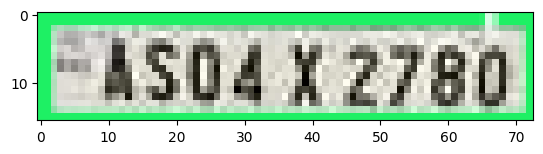

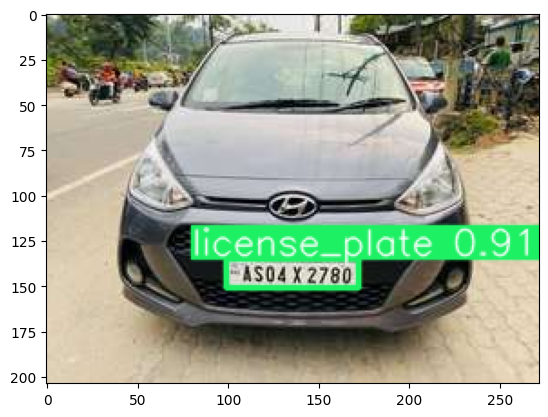

['FAS04X2780']
/kaggle/input/indian-vehicle-dataset/State-wise_OLX/SK/SK3.jpg


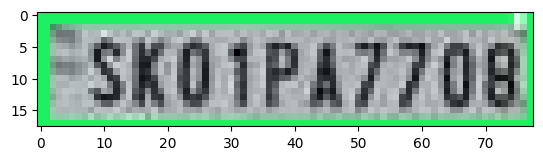

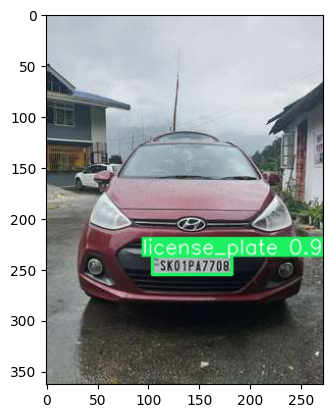

['ESK01P47708']
/kaggle/input/indian-vehicle-dataset/State-wise_OLX/AR/AR3.jpg


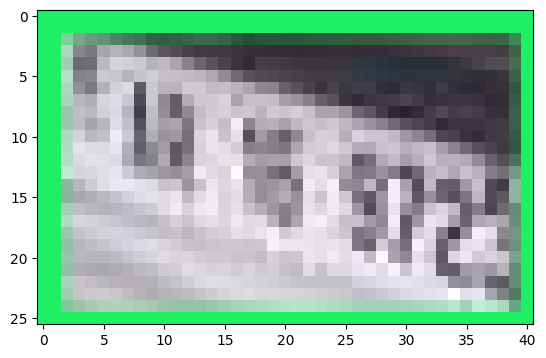

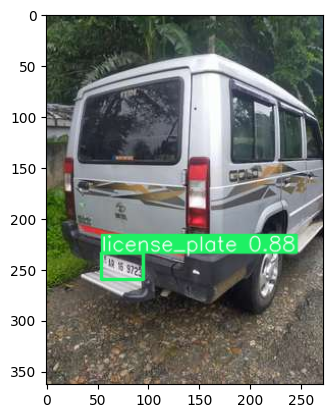

[]
/kaggle/input/indian-vehicle-dataset/State-wise_OLX/AP/AP27.jpg


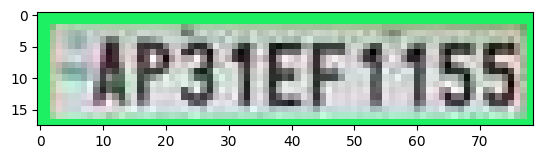

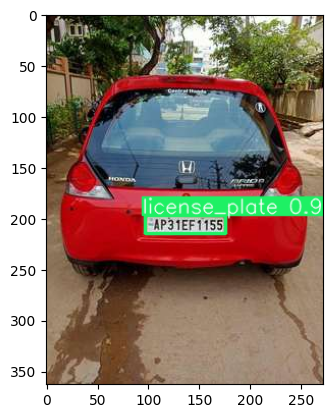

['~AP31EF1155']
/kaggle/input/indian-vehicle-dataset/google_images/fc1f58f0-2f54-4545-8915-2936d08dcce1___new_Skoda_Laura_DSG_Long_Term_Review-125.jpg.jpeg


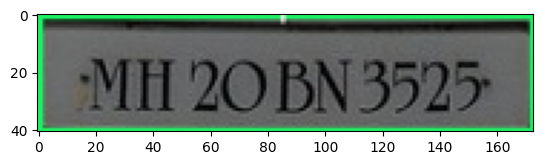

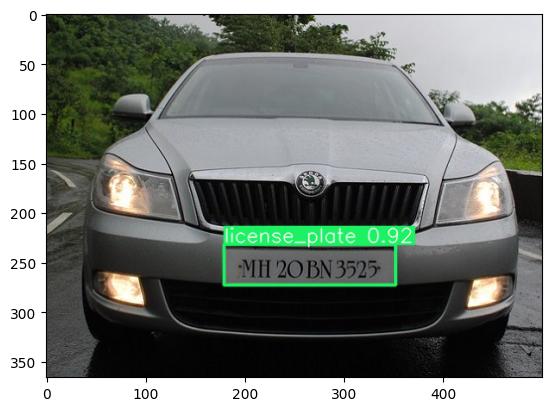

['MHQ0BN3525']
/kaggle/input/indian-vehicle-dataset/google_images/a508ecb5-bfdd-46ba-8640-bb827b7c089c___Volkswagen-Polo.jpg.jpeg


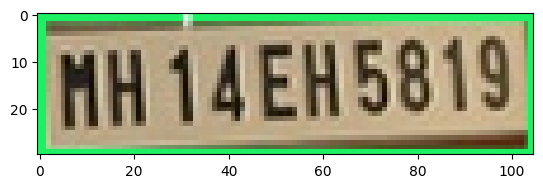

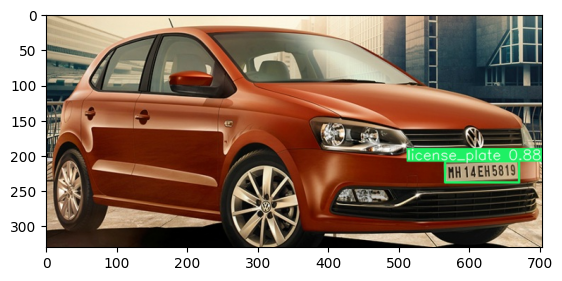

['MH14EH5819']
/kaggle/input/indian-vehicle-dataset/google_images/car-wbs-KL54A2670_00000.png


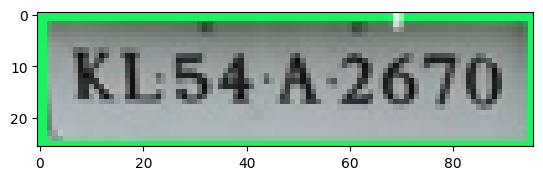

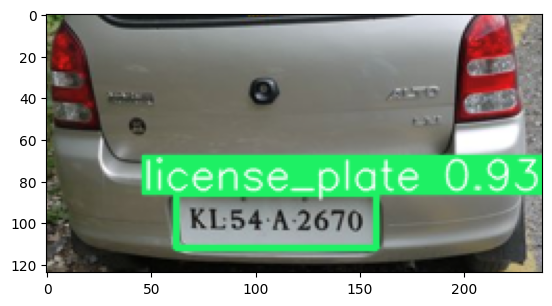

['KL544.2670']


In [35]:
%matplotlib inline
idxs = [0, 1, 2, 3, 4, 5, 6]
for idx in idxs:
    show_plate_detection(idx)
    text_ocr = get_text_easyocr(idx)
    print(text_ocr)

In [36]:
from sklearn.metrics import accuracy_score
import numpy as np
!pip install python-Levenshtein
import Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.9 MB/s eta 0:00:0000:0100:01


In [37]:
# Initialize counters
total = len(df_results)
exact_matches = 0
char_accuracies = []
lev_distances = []

In [38]:
for i in range(total):
    gt = df_results.loc[i, "plate_number"]
    pred = df_results.loc[i, "pred_plate_number"]
    
    if not gt or not pred:
        continue  # Skip empty cases

    # 1. Exact Match
    if gt == pred:
        exact_matches += 1

    # 2. Character-level Accuracy
    matches = sum(1 for a, b in zip(gt, pred) if a == b)
    char_accuracy = matches / max(len(gt), len(pred))
    char_accuracies.append(char_accuracy)

    # 3. Levenshtein Distance
    lev_dist = Levenshtein.distance(gt, pred)
    lev_distances.append(lev_dist)

# Calculate Metrics
exact_match_accuracy = exact_matches / total
average_char_accuracy = np.mean(char_accuracies)
average_lev_distance = np.mean(lev_distances)

# Display
print(f"📌 Total Samples: {total}")
print(f"✅ Exact Match Accuracy: {exact_match_accuracy:.4f}")
print(f"🔠 Average Character-Level Accuracy: {average_char_accuracy:.4f}")
print(f"✂️ Average Levenshtein Distance: {average_lev_distance:.2f}")


📌 Total Samples: 193
✅ Exact Match Accuracy: 0.1710
🔠 Average Character-Level Accuracy: 0.4951
✂️ Average Levenshtein Distance: 2.62
